
# 📘 Module 20: AdaBoost (Adaptive Boosting) – Practice Notebook

This is a **full practice notebook with detailed guidance and TODO blocks**.


## 0. Notebook Setup

We start by importing all required libraries.  


In [1]:
# TODO: Import all required libraries (Done for you)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression


## 1. Understanding the Dataset

You can begin with a **synthetic binary classification dataset**. or with any exisiting dataset.

Focus questions:
- Are the classes easily separable?
- Will a weak learner struggle?


In [2]:
# TODO: Generate a binary classification dataset
# Hint:
# - n_samples around 500
# - n_features = 2
# - class_sep > 1
df = pd.read_csv("water_potability.csv")
print(df.shape)
display(df.head(5))

(3276, 10)


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [3]:
missing_val_cols = df.isnull().sum()[df.isnull().sum() > 0].index
features = df.columns[:-1].tolist()
target = df.columns[-1]
# print(features)
# print(target)

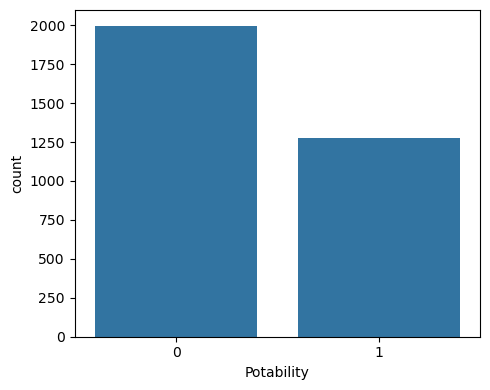

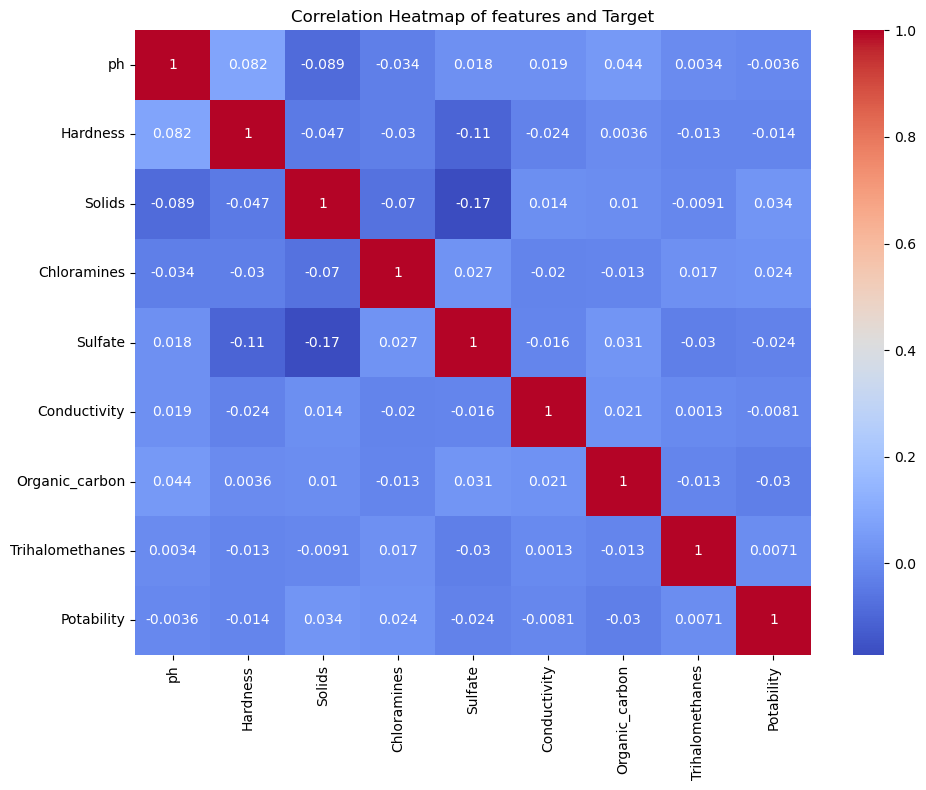

In [4]:
# TODO: Visualize the dataset using a scatter plot
# Color points by class label
plt.figure(figsize=(5,4))
sns.countplot(x = target,data = df)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,8))
corr = df[features[:8] + [target]].corr()
sns.heatmap(corr,annot= True,cmap="coolwarm")
plt.title("Correlation Heatmap of features and Target")
plt.tight_layout()
plt.show()


## 2. Train–Test Split

Before any model training, we split the data.

Why?
- To evaluate generalization
- To avoid lying to ourselves

Standard split:
- 70% training
- 30% testing


In [5]:
# TODO: Split the dataset into training and testing sets
# Use test_size=0.3 and random_state=42
X = df[features]
y = df[target]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)
print(X_train.shape)
print(X_test.shape)

(2457, 9)
(819, 9)



## 3. Baseline Weak Learner (Decision Stump)

Before AdaBoost, we test **one weak learner alone**.

We intentionally restrict the model:
- max_depth = 1
- This is called a **decision stump**

Expectation:
- Accuracy will not be impressive
- That is the point


In [6]:
# TODO: Create a DecisionTreeClassifier with max_depth=1
# SVM, Logistic Regression
# This is our weak learner
dtc = DecisionTreeClassifier(max_depth=1)
dtc_pipe = Pipeline(
    [("imputer", SimpleImputer()), ("Scaler", StandardScaler()), ("model", dtc)]
)
svc = SVC(kernel="rbf", gamma="scale", C=1)
svc_pipe = Pipeline(
    [("imputer", SimpleImputer()), ("Scaler", StandardScaler()), ("model", svc)]
)
log_reg = LogisticRegression(C=1, random_state=42, max_iter=1000)
log_reg_pipe = Pipeline(
    [("imputer", SimpleImputer()), ("Scaler", StandardScaler()), ("model", log_reg)]
)

In [7]:
# TODO: Train the weak learner
# TODO: Predict on test data
# TODO: Calculate and print accuracy
dtc_pipe.fit(X_train,y_train)
dtc_pred = dtc_pipe.predict(X_test)
svc_pipe.fit(X_train,y_train)
svc_pred = svc_pipe.predict(X_test)
log_reg_pipe.fit(X_train,y_train)
log_reg_pred = log_reg_pipe.predict(X_test)
print("Decision Tree Classifier accuracy: ",accuracy_score(y_test,dtc_pred))
print("Support Vector Classifier accuracy: ",accuracy_score(y_test,svc_pred))
print("Logistic Regression Classifier accuracy: ",accuracy_score(y_test,log_reg_pred))

Decision Tree Classifier accuracy:  0.63003663003663
Support Vector Classifier accuracy:  0.6959706959706959
Logistic Regression Classifier accuracy:  0.6227106227106227



## 4. AdaBoost Classifier – Core Practice

Now we combine **many weak learners** using AdaBoost.

Key idea:
- Each learner focuses more on previous mistakes
- Misclassified samples get more attention
- Correctly classified samples slowly matter less


In [8]:
# TODO: Initialize AdaBoostClassifier
# Use:
# - base_estimator = decision stump
# - n_estimators = 50
# - learning_rate = 1.0
def Classifiers(model, acc, model_names,n,lr):
    model_name = model.__class__.__name__
    model_names.append(model_name)
    ada = Pipeline(
        [
            ("Imputer", SimpleImputer()),
            ("Sacaler", StandardScaler()),
            (
                "model",
                AdaBoostClassifier(
                    estimator=model,
                    n_estimators=n,
                    learning_rate=lr,
                ),
            ),
        ]
    )
    ada.fit(X_train, y_train)
    ada_pred = ada.predict(X_test)
    acc.append(accuracy_score(y_test, ada_pred))

In [9]:
# TODO: Train AdaBoost on training data
# TODO: Predict on test data
# TODO: Evaluate accuracy
# TODO: Print classification report
models = [
    DecisionTreeClassifier(max_depth=1),
    SVC(kernel="rbf", C=1, random_state=42, gamma="scale"),
    LogisticRegression(
        random_state=42,
        max_iter=100,
    )
]

acc = []
model_names = []
for model in models:
    Classifiers(model, acc, model_names,50,1)
answer = pd.DataFrame({"Model":model_names,"Accuracy":acc})
display(answer)

,Model,Accuracy
0,DecisionTreeClassifier,0.632479
1,SVC,0.622711
2,LogisticRegression,0.622711



## 5. Weak Learner vs AdaBoost Comparison

Now we compare:
- One weak learner
- Many weak learners working together

Expectation:
- AdaBoost should outperform a single stump
- If not, something is wrong


In [10]:
# TODO: Create a comparison table
# Columns:
# - Model
# - Accuracy



## 6. Effect of Number of Estimators

AdaBoost performance depends heavily on:
- Number of estimators

More is not always better.

Your job:
- Experiment
- Observe
- Plot


In [11]:
# TODO: Try different n_estimators values
# Example: [5, 10, 20, 50, 100]

# Store accuracy for each value
def Classifiers_est(acc, n):
    ada = Pipeline(
        [
            ("Imputer", SimpleImputer()),
            ("Sacaler", StandardScaler()),
            (
                "model",
                AdaBoostClassifier(
                    estimator=DecisionTreeClassifier(max_depth = 1),
                    n_estimators=n,
                    learning_rate=1,
                ),
            ),
        ]
    )
    ada.fit(X_train, y_train)
    ada_pred = ada.predict(X_test)
    acc.append(accuracy_score(y_test, ada_pred))
estimators = [5, 10, 20, 50, 100]
acc_est = []
for est in estimators:
    Classifiers_est(acc_est,est)

ans = pd.DataFrame({"No. of Estimators":estimators,"Accuracy":acc_est})
display(ans)

,No. of Estimators,Accuracy
0,5,0.630037
1,10,0.631258
2,20,0.631258
3,50,0.632479
4,100,0.631258


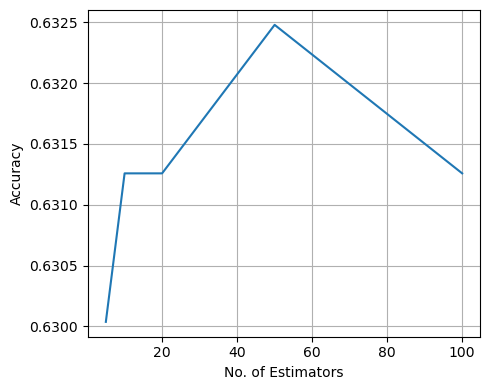

In [27]:
# TODO: Plot n_estimators vs accuracy
# Label axes clearly
plt.figure(figsize=(5,4))
sns.lineplot(x = ans["No. of Estimators"],y = ans["Accuracy"])
plt.tight_layout()
plt.grid()
plt.show()


## 7. Effect of Learning Rate

Learning rate controls **how aggressively** AdaBoost updates sample weights.

Intuition:
- High learning rate → fast but risky
- Low learning rate → slow but stable

You will verify this experimentally.


In [29]:
# TODO: Experiment with different learning_rate values
# Example: [0.01, 0.1, 0.5, 1.0]
def Classifiers_lr(acc, lr):
    ada = Pipeline(
        [
            ("Imputer", SimpleImputer()),
            ("Sacaler", StandardScaler()),
            (
                "model",
                AdaBoostClassifier(
                    estimator=DecisionTreeClassifier(max_depth=1),
                    n_estimators=50,
                    learning_rate=lr,
                ),
            ),
        ]
    )
    ada.fit(X_train, y_train)
    ada_pred = ada.predict(X_test)
    acc.append(accuracy_score(y_test, ada_pred))

Learning_rates = [0.01, 0.1, 0.5, 0.8,1.0]
acc_lr = []
for lr in Learning_rates:
    Classifiers_lr(acc_lr, lr)

ans2 = pd.DataFrame({"Learning Rate": Learning_rates, "Accuracy": acc_lr})
display(ans2)

,Learning Rate,Accuracy
0,0.01,0.630037
1,0.10,0.630037
2,0.50,0.631258
3,0.80,0.633700
4,1.00,0.632479


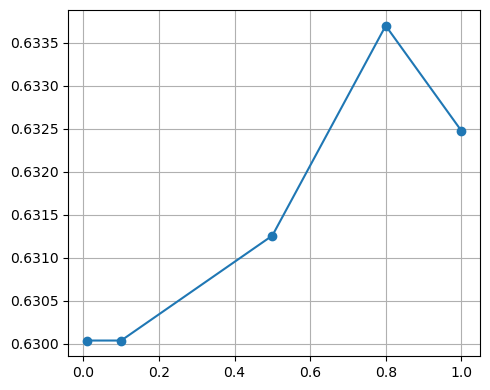

In [33]:
# TODO: Plot learning_rate vs accuracy
plt.figure(figsize=(5,4))
plt.plot(ans2["Learning Rate"],ans2["Accuracy"],marker = "o")
plt.tight_layout()
plt.grid()
plt.show()


## 8. Feature Importance in AdaBoost

AdaBoost can tell us:
- Which features were more influential

This depends on:
- How often a feature is used in splits
- How strong the corresponding learners were


In [ ]:
# TODO: Extract feature importance from AdaBoost
# TODO: Plot feature importance


## 9. Reflection (Mandatory)

Answer in your own words.

1. Why is AdaBoost called *adaptive*?
2. What happens to misclassified samples after each iteration?
3. Why do we prefer weak learners instead of strong ones?
4. When should AdaBoost not be used?



## 10. Bonus Challenge (Optional)

Replace the decision stump with **Logistic Regression** as the base estimator.

Questions:
- Does AdaBoost still work?
- Should you do this in practice?
- Why or why not?


In [16]:
# TODO: Replace DecisionTreeClassifier with LogisticRegression or SVM
# Train AdaBoost again
# Compare performance